### CAMERA CALIBRATION



In [0]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd

####This part of the code lets you use files from your Google Drive account
####You need not use this if you are not using Google Colaboratory
####Running code on Google Colab

(a) Make a folder on Google Drive, upload this file and all the data files provided to you into the same folder

(b) The last part of the URL will serve as the "folder_id" in the line below

If you are unsure, you can read further here : https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive

In [0]:
folder_id = '1KwIsZQsj67k3Y54dtOVshZZzOgUkK1up' # Enter the last part of the URL of the Google Drive folder here

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': '\'' + folder_id + "\' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  
os.chdir(local_download_path)

####PART 1: Given corresponding 2d points in the image and 3d coordinates with known extrinsics, estimate the camera intrinsics of the form given in the CalibrationAssignment.docx

In [0]:
# Code for Part 1 starts here

# Step 1: Load the data file pt_corres.mat
data_part1 = scipy.io.loadmat('pt_corres.mat')
cam_pts_3D = data_part1['cam_pts_3D']         # Load the 3d points
pts_2D = data_part1['pts_2D']                 # Load the corresponding 2d points

#print pts_2D.shape
#print cam_pts_3D.shape

# Step 2: Write your code here to compute the camera intrinsics 
pts_2D_full = np.vstack((pts_2D, [1]*28))

X = np.zeros((1,28));
Y = np.zeros((1,28));
Z = np.zeros((1,28));

X = cam_pts_3D[0,:]
Y = cam_pts_3D[1,:]
Z = cam_pts_3D[2,:]

X = X/Z
Y = Y/Z

cam_3D = np.vstack((X,Y,[1]*28))


cam_3D_inv = np.linalg.pinv(cam_3D)

K = np.matmul(pts_2D_full,cam_3D_inv)
print 'K=', K
# Code for Part 1 ends here

K= [[ 3.38625072e+03  1.27159260e+01  8.52916937e+02]
 [ 1.85319235e+00  3.42886718e+03  6.27551184e+02]
 [-1.11022302e-15  2.99760217e-15  1.00000000e+00]]


####PART 2: Given 2d points on the image and corresponding 3d points in the world-coordinate system, estimate both intrinsics and extrinsics. You need to fill in the code for the function calibrate() in calib_DLT.ipynb before running the cell below

(56, 12)
(12, 12)
P =  [[ 2.24468524e-01  2.82252106e-02 -4.46581005e-02  6.47418343e-01]
 [ 3.13049122e-03 -1.77345292e-01 -1.43567369e-01  6.89636308e-01]
 [-8.96065658e-07  2.74079257e-05 -5.24236468e-05  1.17447045e-03]]
K =  [[ 3.80781877e+03 -8.16178109e+00  8.32399977e+02]
 [ 0.00000000e+00  3.78129094e+03  7.60763925e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R =  [[ 0.99974008  0.02211926 -0.00552403]
 [ 0.01704062 -0.88594483 -0.46347748]
 [-0.01514576  0.46326288 -0.88609148]]
t =  [-1.46772505 -0.91125501 19.85150442]
(3, 28)
('Error', 0.4413167951853338)


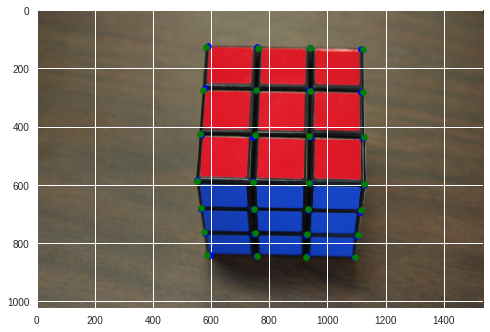

In [0]:
def calibrate(x,X):
  '''
  This function computes camera projection matrix from 3D scene points
  and corresponding 2D image points with the Direct Linear Transformation (DLT).
  
  Usage:
  P = calibrate(x, X)
  
  Input:
  x: 2xn image points
  X: 3xn scene points
  
  Output:
  P: 3x4 camera projection matrix
  
  '''
  
  # Your code goes here
  
  # Hint 1: Convert to homogeneous coordinates first
  # Hint 2: np.hstack and np.vstack are useful functions
  
  # Warning: The svd function from Numpy returns U, Sigma and V_transpose (not V, unlike Matlab)
  
  X1 = np.zeros((1,28))
  Y1 = np.zeros((1,28))
  Z1 = np.zeros((1,28));
  
  X1 = X[0,:]
  Y1 = X[1,:]
  Z1 = X[2,:]
  
  #X1 = X1/Z1
  #Y1 = Y1/Z1

  cam_3D = np.array(np.vstack((X1,Y1,Z1,[1]*28)))
  pts_2D = np.array(np.vstack((x, [1]*28)))
   
  A1 = np.zeros((1,12))
  A2 = np.zeros((1,12))
  A = np.zeros((2*28,12))

  for i in range(0,28):
    A1 = np.hstack((np.array([[0]*4]),-1*np.array([cam_3D[:4,i]]), pts_2D[1,i]*np.array([cam_3D[:4,i]])))
    A2 = np.hstack((np.array([cam_3D[:4,i]]),np.array([[0]*4]), -1*pts_2D[0,i]*np.array([cam_3D[:4,i]])))
    if i<1:
      A = np.vstack((A1,A2))
    else:
      A = np.vstack((A,A1,A2))
      
  print A.shape
  
  [U,S,V] = svd(A)
  V1 = np.transpose(V)
  
  #print V1[:3,5:]
  #print V1[3:6,5:]
  #print V1[6:9,5:]
  
  print V1.shape
  
  P = V1[:,-1].reshape(3,4)
  
  return P

#######################################################################################################################################################################################################

def P_to_KRt(P):
  '''
  
  This function computes the decomposition of the projection matrix into intrinsic parameters, K, and extrinsic parameters Q (the rotation matrix) and t (the translation vector)
  
  Usage:
  K, Q, t = P_to_KRt(P)
  
  Input: 
  P: 3x4 projection matrix
  
  Outputs:
  K: 3x3 camera intrinsics
  Q: 3x3 rotation matrix (extrinsics)
  t: 3x1 translation vector(extrinsics)
  
  '''
  
  M = P[0:3,0:3]
  
  R, Q = rq(M)
    
  K = R/float(R[2,2])
  
  if K[0,0] < 0:
    K[:,0] = -1*K[:,0]
    Q[0,:] = -1*Q[0,:]
    
  if K[1,1] < 0:
    K[:,1] = -1*K[:,1]
    Q[1,:] = -1*Q[1,:]
  
  if det(Q) < 0:
    print 'Warning: Determinant of the supposed rotation matrix is -1'
  
  P_3_3 = np.dot(K,Q)
  
  P_proper_scale = (P_3_3[0,0]*P)/float(P[0,0])
  
  t = np.dot(inv(K), P_proper_scale[:,3])
  
  return K, Q, t

#######################################################################################################################################################################################################

# Code for Part 2 starts here

# Step 1 : Load the data files rubik_2D_pts.mat and rubik_3d_pts.mat

pts_3d = scipy.io.loadmat('rubik_3D_pts.mat')['pts_3d'] # 3D points in the world-coordinate system with one of the corners of the Rubik's cube as the origin; side of each smaller cube = 1 unit
pts_2d = scipy.io.loadmat('rubik_2D_pts.mat')['pts_2d'] # The corresponding 2D points on the image rubik_cube.jpg

#print pts_2d.shape
#print pts_3d.shape


# Step 2: Get the camera calibration matrix P
  
P = calibrate(pts_2d, pts_3d)     # You need to fill in the code for this function before you execute this part of the code

print 'P = ', P 

# Step 3: Use the function P_to_KRt (already written for you) to decompose P into intrinsics (K) and extrinsics (R and t)
[K, R, t] = P_to_KRt(P)

print 'K = ', K
print 'R = ', R
print 't = ', t
pts_3D = np.array(np.vstack((pts_3d, [1]*28)))

# Write code here to compute the average reprojection error (averaged over the 28 points given)

pts_reproj = np.zeros((3,28))
for i in range(0,28):
  pts_reproj[:,i] = np.dot(P,np.transpose(pts_3D[:,i]))
  
print pts_reproj.shape

x1 = np.zeros((1,28))
y1 = np.zeros((1,28))
z1 = np.zeros((1,28));
  
x1 = pts_reproj[0,:]
y1 = pts_reproj[1,:]
z1 = pts_reproj[2,:]
  
x1 = x1/z1
y1 = y1/z1

new_pts = np.zeros((3,28))
new_pts = np.array(np.vstack((x1,y1)))

#Error=np.sqrt(np.square(np.subtract(pts_2d, new_pts)).mean())

Error = 0
for i in range(0,28):
  Error += (((pts_2d[0,i]-new_pts[0,i])**2) + ((pts_2d[1,i]-new_pts[1,i])**2))

Error = np.sqrt(Error)/28
print('Error',Error)

image_name = 'rubik_cube.jpg'
im = plt.imread(image_name)
implot = plt.imshow(im)

plt.scatter(x=[pts_2D[0,:]], y=[pts_2D[1,:]], c='b', s=40)
plt.scatter(x=[new_pts[0,:]], y=[new_pts[1,:]], c='g', s=40)
plt.show()


# Display the given 2D points and the reprojected 2D points on the Rubik's Cube image provided

# Code for Part 2 ends here